# Identify Fraud from Enron Email

### Stefan Dulman

## 1. Data Investigation

*Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?*

This project showcases notions from the machine learning course applied to the Enron dataset. Namely, the goal is to identify the persons of interest in the scandal using several features extracted from financial and email records. The reasoning behind it could be that the behavior of persons who committed fraud should be somehow different than the regular population. These differences should be reflected in financial data, communication patterns, etc. and we can train algorithms to exploit and expose these differences.

The dataset is provided in the form of a dictionary of dictionaries. We converted it to a dataframe with the following characteristics:

In [2]:
%matplotlib inline

import seaborn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# function replaces string NaN with float('nan')
def replace_nan(x):
    x = x.astype('float')
    x[np.logical_not(np.isfinite(x))] = float('nan')
    return x

# load the data
with open("/Users/stefan/Desktop/udacity/ud120-projects/final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# convert dictionary of dictionaries to a data frame
x = pd.DataFrame(data=data_dict).transpose()

# remove the email addresses
x.drop('email_address', axis=1, inplace=True)

# convert to floats
x = x.astype(float)

# transform the messages as suggested in the lecture
x['fraction_to'] = x['from_poi_to_this_person'].as_matrix() / x['to_messages'].as_matrix()
x['fraction_from'] = x['from_this_person_to_poi'].as_matrix() / x['from_messages'].as_matrix()

# delete the oter four features
x.drop('from_poi_to_this_person', axis=1, inplace=True)
x.drop('from_this_person_to_poi', axis=1, inplace=True)
x.drop('to_messages', axis=1, inplace=True)
x.drop('from_messages', axis=1, inplace=True)

# change the sign of the 'deffered income' and the few other entries that are negative
x[x < 0] = -x[x < 0]
# change the string nan to the float nan
for c in x.columns:
    x[c] = replace_nan(x[c])

# remove some bogus entries: the travel agency in the park and total:
x.drop('THE TRAVEL AGENCY IN THE PARK', axis=0, inplace=True)
x.drop('TOTAL', axis=0, inplace=True)


    
# print some of the characteristics of the data set
print 'Available columns:'
print ''
i = 1
lv1 = list()
lv2 = list()
featurelist = []
for c in x.columns:
    v1 = np.sum(np.isfinite(x[c].as_matrix())) / 144.0
    v2 = np.sum(np.isfinite(x[c].as_matrix()) * x['poi'])
    lv1.append(v1)
    lv2.append(v2)
    print 'column', i, '\t-\t', c, ' -- percentage values %.2f' % v1, ' -- nr. poi', v2
    i = i + 1
    # select the features of interest
    if c != 'poi':
        if v1 > 0.5:
            if v2 > 10:
                featurelist.append(c)
print ''
print 'Number of records:', len(x.axes[0])

# compute the number of NaN in the dataset
y = x.as_matrix()
print 'Missing data entries: %0.2f' % (100.0 * np.sum(np.isnan(y)) / y.shape[0] / y.shape[1]), '%'

# print the number of persons of interest
print 'Number of persons of interest %0.0f' % (np.sum(x['poi']))

# create the datasets
temp = list(featurelist)
temp.append('poi')
datanan = x[temp].copy().dropna()
targetnan = datanan['poi'].copy()
datanan.drop('poi', axis=1, inplace=True)

datanansc = RobustScaler().fit_transform(datanan)

dataimp = x[featurelist].copy()
targetimp = x['poi'].copy()
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
dataimp = pd.DataFrame(imp.fit(dataimp).transform(dataimp), columns=featurelist)

dataimpsc = RobustScaler().fit_transform(dataimp)

Available columns:

column 1 	-	bonus  -- percentage values 0.56  -- nr. poi 16.0
column 2 	-	deferral_payments  -- percentage values 0.26  -- nr. poi 5.0
column 3 	-	deferred_income  -- percentage values 0.33  -- nr. poi 11.0
column 4 	-	director_fees  -- percentage values 0.11  -- nr. poi 0.0
column 5 	-	exercised_stock_options  -- percentage values 0.70  -- nr. poi 12.0
column 6 	-	expenses  -- percentage values 0.65  -- nr. poi 18.0
column 7 	-	loan_advances  -- percentage values 0.02  -- nr. poi 1.0
column 8 	-	long_term_incentive  -- percentage values 0.45  -- nr. poi 12.0
column 9 	-	other  -- percentage values 0.63  -- nr. poi 18.0
column 10 	-	poi  -- percentage values 1.00  -- nr. poi 18.0
column 11 	-	restricted_stock  -- percentage values 0.76  -- nr. poi 17.0
column 12 	-	restricted_stock_deferred  -- percentage values 0.12  -- nr. poi 0.0
column 13 	-	salary  -- percentage values 0.65  -- nr. poi 17.0
column 14 	-	shared_receipt_with_poi  -- percentage values 0.60  -- nr.

The dataset is actually quite small and we have the task of identifying roughly 12% specific points. Notably, roughly 45% of the data set is missing.

Regarding outliers, by visual inspection of the data set, we noticed two entries ('TOTAL' and 'THE TRAVEL AGENCY IN THE PARK') which we removed. Ignoring for now the NaN values in the dataset, we had a look at the distribution of all variables, the first three being shown below. We were interested in how the distribution of the original data and after a logarithmic function was applied looked like, and what happened when outliers were removed.

Feature: bonus - 0


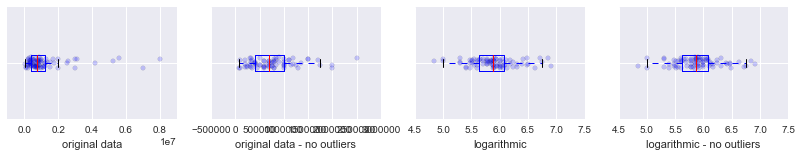

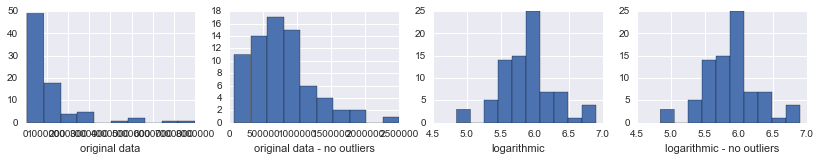

Feature: deferral_payments - 1


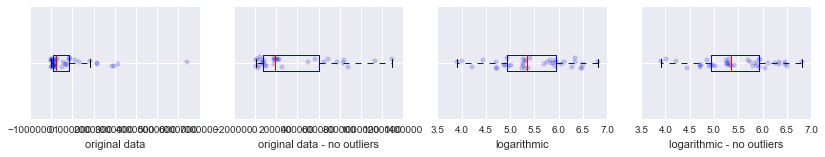

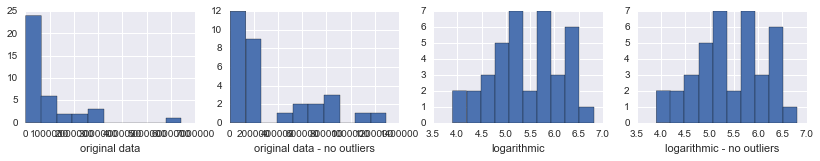

Feature: deferred_income - 2


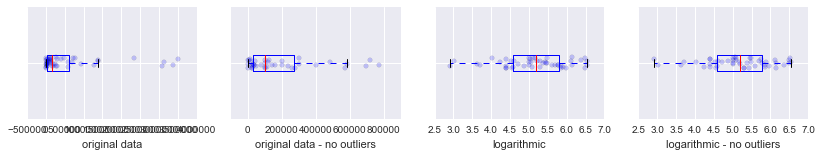

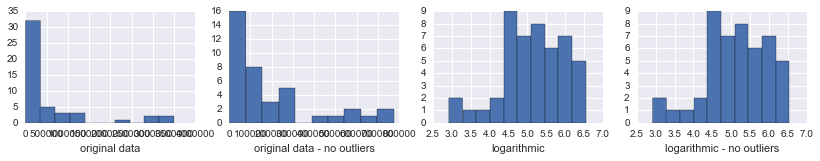

In [3]:
# i adapted the function below to work with NaN values:
# http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def is_not_outlier(points, thresh=3.5):
    # exclude nan values from input values
    nanpoints = points[np.isfinite(points)]
    # compute median of finite values
    median = np.median(nanpoints) 
    # compute difference and take square root
    diff = np.squeeze((points - median)**2)
    diff = np.sqrt(diff)
    # compute med_abs_deviation of finite values only
    nandiff  = diff[np.isfinite(diff)]
    med_abs_deviation = np.median(nandiff)
    # compute modified z score
    modified_z_score = 0.6745 * diff / med_abs_deviation
    # return true if point is not an outlier; nan if value was nan
    return modified_z_score <= thresh


# Returns a tuple (in reverse order): the actual number of values over which correlation 
# is computed and how many of those are poi.
def get_finite_count(x, poi):
    index = np.isfinite(x)
    # get the count of finite elements
    cnt = np.sum(index)
    # get the number of poi we perform the correlation over
    cntpoi = np.sum(poi[index])
    # return values
    return [int(cntpoi), int(cnt)]

# custom plot
def myplot_box(y, xlabel):
    x = np.ones(len(y)) + (np.random.rand(len(y)) - 0.5)/10
    plt.boxplot(y, vert=False)
    plt.scatter(y, x, alpha=0.2)
    plt.yticks([1], [''])
    plt.xlabel(xlabel)
    
# custom plot
def myplot_hist(y, xlabel):
    plt.hist(y)
    plt.xlabel(xlabel)
    
# Returns all values which are not +/- infinity or nan
def clean(x):
    return x[np.isfinite(x)]

# go through the columns and select the features of interest orig or log, with or without outliers
res = list()

cnt = 0
for c in x.columns:
    
    # exlude 'poi'
    if c == 'poi':
        continue
        
    # compute the log of the series
    logx = pd.Series(np.log10(x[c]))
    # replace the -inf with nan
    logx[np.isinf(logx)] = float('nan')

    # remove the outliers in the two types of series
    xnoout = x[c].copy()
    index = is_not_outlier(xnoout)
    xnoout[np.logical_not(index)] = float('nan')

    # check for nan
    logxnoout = logx.copy()
    index = is_not_outlier(logxnoout)
    logxnoout[np.logical_not(index)] = float('nan')

    v1 = abs(x[c].corr(x['poi']))
    v2 = abs(logx.corr(x['poi']))
    v3 = abs(xnoout.corr(x['poi']))
    v4 = abs(logxnoout.corr(x['poi']))

    u1 = get_finite_count(x[c], x['poi'])
    u2 = get_finite_count(logx, x['poi'])
    u3 = get_finite_count(xnoout, x['poi'])
    u4 = get_finite_count(logxnoout, x['poi'])

    if cnt < 3:

        print 'Feature:', c, '-', cnt
        #print 'Correlation original series:     ', '%.3f' % v1, '\t', u1
        #print 'Correlation logarithmic series:  ', '%.3f' % v2, '\t', u2
        #print 'Correlation orig. no-outliers:   ', '%.3f' % v3, '\t', u3
        #print 'Correlation log. no-outliers:    ', '%.3f' % v4, '\t', u4

        plt.figure(figsize=(14, 2))
        plt.subplot(1,4,1)
        myplot_box(clean(x[c]), 'original data')
        plt.subplot(1,4,2)
        myplot_box(clean(xnoout), 'original data - no outliers')
        plt.subplot(1,4,3)
        myplot_box(clean(logx), 'logarithmic')
        plt.subplot(1,4,4)
        myplot_box(clean(logxnoout), 'logarithmic - no outliers')    
        plt.show()

        plt.figure(figsize=(14, 2))
        plt.subplot(1,4,1)
        myplot_hist(clean(x[c]), 'original data')
        plt.subplot(1,4,2)
        myplot_hist(clean(xnoout), 'original data - no outliers')
        plt.subplot(1,4,3)
        myplot_hist(clean(logx), 'logarithmic')
        plt.subplot(1,4,4)
        myplot_hist(clean(logxnoout), 'logarithmic - no outliers')    
        plt.show()

    res.append([c, v1, v2, v3, v4, u1, u2, u3, u4])

    cnt = cnt + 1

We notice that some features are unusable. For example, the 'director_fee' contains mostly NaN values. After filtering these, only 17 records remain, and none of them is a person of interest. Similar cases happen for example for 'loan_advances' and 'restricted_stock_deferred'. 

## 2. Feature Selection

*What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it.*

Feature selection for this data set was a difficult task. This is part due to small size of the data set and imbalance between the poi/non-poi data points. As we will see later, various algorithms chose a complete different set of features while achieving similar performance. 

We followed the indications given in the classes and converted the number of emails variables into two variables, showing the percentage of emails received by a person from a poi ('fraction_from') and sent to a poi ('fraction_to'). We dropped the email variable.


To get a bit more insight into the variables, we plot the correlation of each variable with the poi:

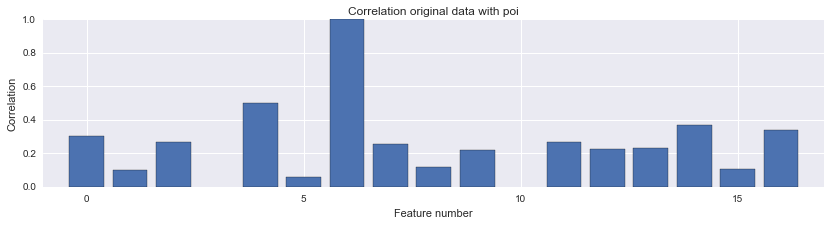

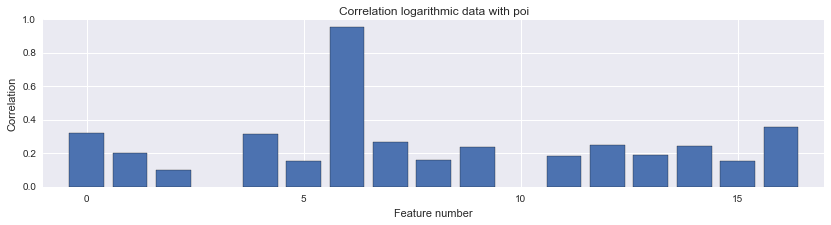

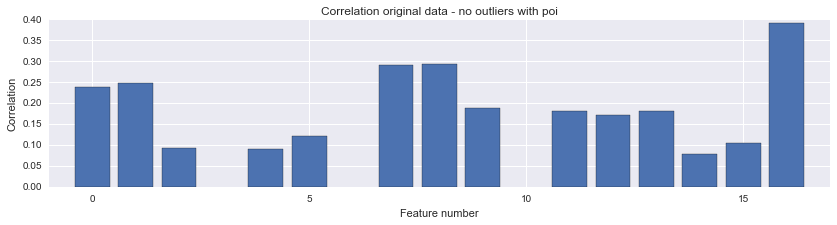

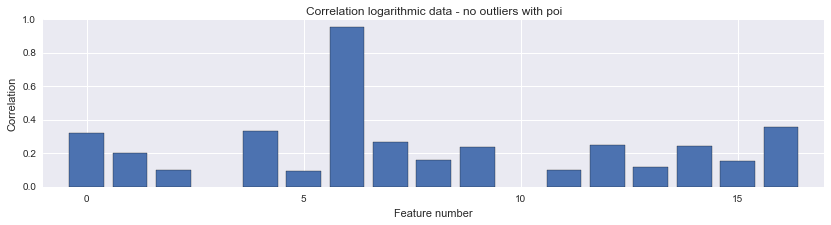

In [4]:
r_names    = list()
r_corr     = list()
r_corrlog  = list()
r_ocorr    = list()
r_ocorrlog = list()
c_corr     = list()
c_corrlog  = list()
c_ocorr    = list()
c_ocorrlog = list()

for n,v1,v2,v3,v4,u1,u2,u3,u4 in res:
    r_names.append(n)
    r_corr.append(v1)
    r_corrlog.append(v2)
    r_ocorr.append(v3)
    r_ocorrlog.append(v4)
    c_corr.append(u1)
    c_corrlog.append(u2)
    c_ocorr.append(u3)
    c_ocorrlog.append(u4)

c_corr     = np.array(c_corr)
c_corrlog  = np.array(c_corrlog)
c_ocorr    = np.array(c_ocorr)
c_ocorrlog = np.array(c_ocorrlog)

r_corr     = np.array(r_corr)
r_corrlog  = np.array(r_corrlog)
r_ocorr    = np.array(r_ocorr)
r_ocorrlog = np.array(r_ocorrlog)

plt.figure(figsize=(14, 3))
plt.bar(np.arange(len(r_names)) - 0.4, r_corr)
plt.title('Correlation original data with poi')
plt.xlim([-1, 17])
plt.xlabel('Feature number')
plt.ylabel('Correlation')
plt.show()

plt.figure(figsize=(14, 3))
plt.bar(np.arange(len(r_names)) - 0.4, r_corrlog)
plt.title('Correlation logarithmic data with poi')
plt.xlim([-1, 17])
plt.xlabel('Feature number')
plt.ylabel('Correlation')
plt.show()

plt.figure(figsize=(14, 3))
plt.bar(np.arange(len(r_names)) - 0.4, r_ocorr)
plt.title('Correlation original data - no outliers with poi')
plt.xlim([-1, 17])
plt.xlabel('Feature number')
plt.ylabel('Correlation')
plt.show()

plt.figure(figsize=(14, 3))
plt.bar(np.arange(len(r_names)) - 0.4, r_ocorrlog)
plt.title('Correlation logarithmic data - no outliers with poi')
plt.xlim([-1, 17])
plt.xlabel('Feature number')
plt.ylabel('Correlation')
plt.show()


To refine the information presented so far even more, we draw also the percentage of the available poi values in the modified variables versus the correlation of the column with poi. We are interested in the values closer to the coordinate (1,1) - the ideal situation in which the modified column contains all 18 poi values and is fully correlated with the target variable.

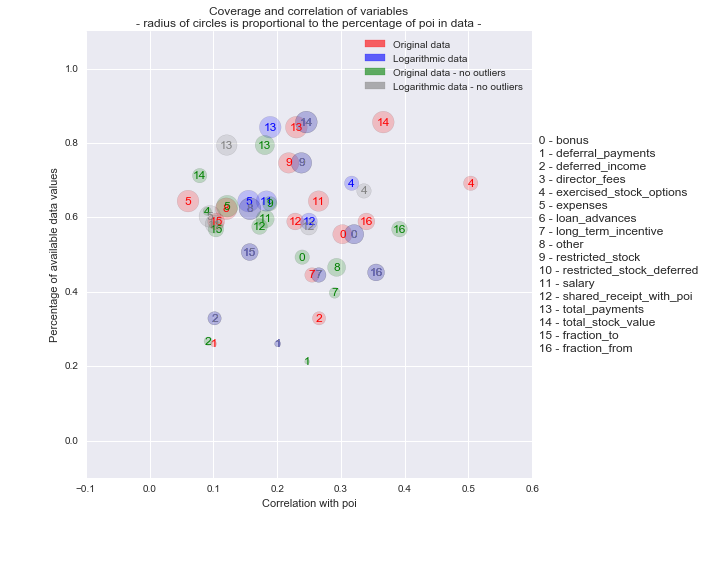

In [5]:
# plot the amount of data versus correlation, color code the number of pois remaining
import matplotlib.patches as mpatches

def cplot1(x, y, r, color):
    area = 150 * np.pi * r**2
    plt.scatter(x, y, area, c=color, alpha=0.2)
    for label, x, y in zip(range(x.shape[0]), x, y):
        plt.annotate(label, xy = (x, y), xytext = (0,0), textcoords = 'offset points',
                     horizontalalignment='center', verticalalignment='center', color=color)
    return res
    
rp  = mpatches.Patch(color='red',   label='Original data', alpha = 0.6)
bp  = mpatches.Patch(color='blue',  label='Logarithmic data', alpha = 0.6)
gp  = mpatches.Patch(color='green', label='Original data - no outliers', alpha = 0.6)
grp = mpatches.Patch(color='gray',  label='Logarithmic data - no outliers', alpha = 0.6)

plt.figure(figsize=(8, 8))
cplot1(r_corr, c_corr[:,1]/146.0, c_corr[:,0]/18.0, 'red')
cplot1(r_corrlog, c_corrlog[:,1]/146.0, c_corrlog[:,0]/18.0, 'blue')
cplot1(r_ocorr, c_ocorr[:,1]/146.0, c_ocorr[:,0]/18.0, 'green')
cplot1(r_ocorrlog, c_ocorrlog[:,1]/146.0, c_ocorrlog[:,0]/18.0, 'gray')
plt.xlabel('Correlation with poi')
plt.ylabel('Percentage of available data values')
plt.xlim([-0.1, 0.6])
plt.ylim([-0.1, 1.1])
# draw legend
plt.legend(handles=[rp, bp, gp, grp])
# draw numbers - names

cnt = 0
for i in r_names:
    plt.annotate("  " + str(cnt) + " - " + i, xy = (0.6, 0.8 - cnt*0.035), xytext = (0, 0), textcoords = 'offset points')
    cnt = cnt + 1

plt.title('Coverage and correlation of variables\n- radius of circles is proportional to the percentage of poi in data -')
    
plt.show()

In [6]:
# columns we will use as such
cols_orig = []
# columns we will use after log function is applied (17,4,15)
cols_log = ['total_stock_value', 'shared_receipt_with_poi', 'total_payments']
# original columns from which we will remove outliers
cols_oorig = ['fraction_from', 'other']
# log columns from which we will remove outliers (18,0)  12  #'restricted_stock',
cols_olog = ['bonus', 'exercised_stock_options', 'restricted_stock', 'long_term_incentive']  
# compose full feature list
features_list = cols_orig + cols_log + cols_oorig + cols_olog

# create new variable and delete non-selected columns
target = x['poi'].copy().as_matrix()
data = x[features_list].copy().as_matrix()

# figure out how many columns contain nan-s
resnan = np.array([0,0,0,0,0,0,0,0,0,0,0])
respoi = np.array([0,0,0,0,0,0,0,0,0,0,0])
index = []
for i in range(data.shape[0]):
    # count numbers of nan-s
    v1 = np.sum(np.logical_not(np.isfinite(data[i,:])))
    resnan[v1] = resnan[v1] + 1
    respoi[v1] = respoi[v1] + x['poi'][i]
    
    if v1 < 20:
        index.append(i)
        
index = np.array(index)
        
for i in range(0,data.shape[1]+1):
    print "nr. lines with", i, 'nan values:\t', resnan[i], '\t- poi values:', respoi[i] 

# filter the lines with more than 3 nans
data = data[index, :]
target = target[index]
#print data.shape
#print target.shape

nr. lines with 0 nan values:	36 	- poi values: 7
nr. lines with 1 nan values:	19 	- poi values: 6
nr. lines with 2 nan values:	15 	- poi values: 1
nr. lines with 3 nan values:	16 	- poi values: 2
nr. lines with 4 nan values:	18 	- poi values: 1
nr. lines with 5 nan values:	9 	- poi values: 1
nr. lines with 6 nan values:	14 	- poi values: 0
nr. lines with 7 nan values:	6 	- poi values: 0
nr. lines with 8 nan values:	10 	- poi values: 0
nr. lines with 9 nan values:	1 	- poi values: 0


Graphically, this information looks like the graph below.It shows the number of data points that are not NaN values in each feature (as a percentage) versus how many poi-s are contained. We decided to select all the variables that contain more than 50% of data values which are not NaNs and more than 10 poi-s (this decision is supported by the match with the previous graphs).


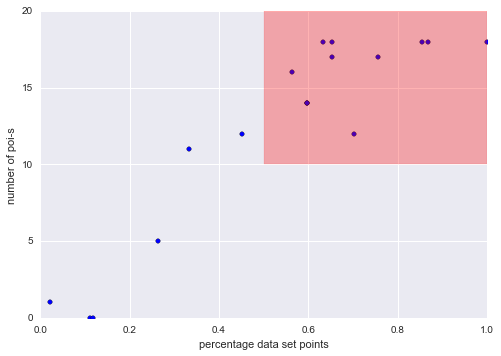

Selected features for final experiment: ['bonus', 'exercised_stock_options', 'expenses', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'total_payments', 'total_stock_value', 'fraction_to', 'fraction_from']


In [7]:

plt.figure()
plt.scatter(lv1, lv2)
plt.xlim([0, 1])
plt.ylim([0, 20])
plt.xlabel('percentage data set points')
plt.ylabel('number of poi-s')
plt.axvspan(0.5, 1, 0.5, 1, color='red', alpha=0.3)\

plt.show()

print 'Selected features for final experiment:', featurelist

For the given data set, the feature importance ranking changes function of the used algorithm. For example, running a random forrest classifier with the default parameters on the whole data twice, leads to the following two rankings. To check that the two runs are consistent, we also estimated the accuracy of the specific random forrest parameter set via three-fold cross-validation (and it led to similar results).

Accuracy: 0.75 (+/- 0.09)


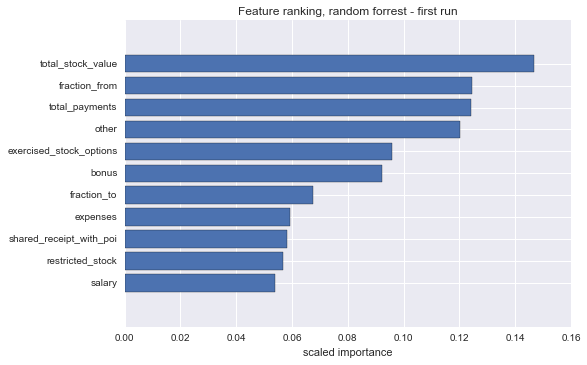

Accuracy: 0.78 (+/- 0.13)


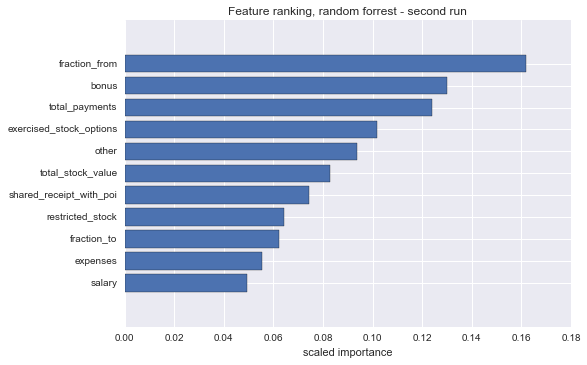

In [8]:
# train a decision tree and print importance of variables
def printimportancetree(data, target, title):
    # run  tree classifier on all data
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=4)
    clf.fit(data, target)
    
    # print the crossvalidation score for this estimator
    scores = cross_val_score(clf, data, target, cv=3)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # plot importances
    imp = clf.feature_importances_
    indices = np.argsort(imp)
    
    plt.figure()
    plt.title(title)
    plt.barh(range(len(indices)), imp[indices], align='center')
    plt.yticks(range(len(indices)), data.axes[1][indices])
    plt.xlabel('scaled importance')
    plt.show()
    
printimportancetree(datanan, targetnan, "Feature ranking, random forrest - first run")
printimportancetree(datanan, targetnan, "Feature ranking, random forrest - second run")

For the remaining part of this project we will use four data sets, all made up of the variables mentioned above:

- datanan - the lines containing nan values are droppped
- datanansc - the lines containing nan values are droppped and the data is scaled with RobustScaler function
- dataimp - the nan values are replaced with the median value for the respective variable
- dataimpsc - same as above, additional scaling is performed

## 3. Algorithm Selection and Tuning

*What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?*

The sklearn library makes it easy to test a large number of classifiers. We have tried: KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GaussianNB, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis. 

Additionally, various versions of SVC were performed. Unfortunatelly the sklearn implementation is not stable and in many cases the random choices for test/train datasets crashed the python interpreter (the issue received a lot of attention on the sklearn bug report list).

Below we report the performances of the classifiers on the original and modified data:

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

names = [
        #'SVC linear',
        #'SVC',
        'KNeighborsClassifier',
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'AdaBoostClassifier',
        'GaussianNB',
        'LinearDiscriminantAnalysis',
        'QuadraticDiscriminantAnalysis']

classifiers = [
        #SVC(kernel="linear", C=0.3),
        #SVC(gamma=2, C=1),
        KNeighborsClassifier(3),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10),
        AdaBoostClassifier(),
        GaussianNB(),
        LinearDiscriminantAnalysis(),
        QuadraticDiscriminantAnalysis()]


def tryclassifiers(data, target):

    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=100)
    
    lp = list()
    lr = list()
    
    print '---------------------------------'
    
    for name, clf in zip(names, classifiers):
        
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        p, r, f, s = precision_recall_fscore_support(y_test, pred) 
        print name
        print 'precision:', p[1]
        print 'recall:   ', r[1]
        #print 'f-score:  ', f
        print 'suport:   ', s
        print confusion_matrix(y_test, pred)
        lp.append(p[1])
        lr.append(r[1])
    
    print '---------------------------------'

print 'Datanan:'
tryclassifiers(datanan, targetnan)

print 'Datanansc:'
tryclassifiers(datanansc, targetnan)

print 'Dataimp:'
tryclassifiers(dataimp, targetimp)

print 'Dataimpsc:'
tryclassifiers(dataimpsc, targetimp)


Datanan:
---------------------------------
KNeighborsClassifier
precision: 0.0
recall:    0.0
suport:    [9 4]
[[9 0]
 [4 0]]
DecisionTreeClassifier
precision: 0.666666666667
recall:    0.5
suport:    [9 4]
[[8 1]
 [2 2]]
RandomForestClassifier
precision: 0.0
recall:    0.0
suport:    [9 4]
[[9 0]
 [4 0]]
AdaBoostClassifier
precision: 1.0
recall:    0.5
suport:    [9 4]
[[9 0]
 [2 2]]
GaussianNB
precision: 1.0
recall:    0.25
suport:    [9 4]
[[9 0]
 [3 1]]
LinearDiscriminantAnalysis
precision: 0.5
recall:    0.5
suport:    [9 4]
[[7 2]
 [2 2]]
QuadraticDiscriminantAnalysis
precision: 0.0
recall:    0.0
suport:    [9 4]
[[9 0]
 [4 0]]
---------------------------------
Datanansc:
---------------------------------
KNeighborsClassifier
precision: 0.0
recall:    0.0
suport:    [9 4]
[[9 0]
 [4 0]]
DecisionTreeClassifier
precision: 0.4
recall:    0.5
suport:    [9 4]
[[6 3]
 [2 2]]
RandomForestClassifier
precision: 0.0
recall:    0.0
suport:    [9 4]
[[9 0]
 [4 0]]
AdaBoostClassifier
precis

Based on the previous results, four algorithms have promising results: LinearDiscriminantAnalysis, KNeighborsClassifier, RandomForestClassifier and AdaBoost. We will tune the parameters of these algorithms, using the datanan dataset. 

By tuning we understand scanning the space of parameters for a specific classifier, in order to find the best combination which will lead to the most accurate result. We will be using the GridSearch function which makes use of crossvalidation for each vector in the parameter space to obtain an estimate of the classifier performance.

Below are the parameters for various algorithms. For example, for the ada boost classifier, the algorithm will combine each of the specified value for the n_estimators with each value of the learning_rate and run crossvalidation on each of the 12 possible combinations. The combination of parameters which produces the highest score will be reported as a result.

- DecisionTreeClassifier: 'criterion': ['gini', 'entropy'], 'max_depth': [1,2,5,None], 'max_features': ['sqrt', 'log2', 1]
- RandomForestClassifier: 'n_estimators': [25, 50, 100], 'max_depth': [1, 2, 5, 10], 'min_weight_fraction_leaf': [0, 0.1, 0.2]
- AdaBoostClassifier: 'n_estimators': [25, 50, 100], 'learning_rate': [1, 0.9, 0.5, 0.1]
- LinearDiscriminantAnalysis: 'solver': ['svd', 'lsqr', 'eigen']


In [11]:
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

params_dtc = { 'criterion': ['gini', 'entropy'],
               'max_depth': [1,2,5,None],
               'max_features': ['sqrt', 'log2', 1] }
params_rfc = { 'k2__k': [8,9,10,11],
               'c2__n_estimators': [25, 50, 100],
               'c2__max_depth': [1, 2, 5, 10],
               'c2__min_weight_fraction_leaf': [0, 0.1, 0.2] }
params_abc = { 'k3__k': [8,9,10,11],
               'c3__n_estimators': [25, 50, 100],
               'c3__learning_rate': [1, 0.9, 0.5, 0.1] }
params_lda = { 'k4__k': [8,9,10,11],
               'c4__solver': ['svd', 'lsqr', 'eigen'] }


c1 = DecisionTreeClassifier()
c2 = RandomForestClassifier()
c3 = AdaBoostClassifier()
c4 = LinearDiscriminantAnalysis()

k1 = SelectKBest(k=1)
k2 = SelectKBest(k=1)
k3 = SelectKBest(k=1)
k4 = SelectKBest(k=1)

pp2 = Pipeline([('k2', k2), ('c2', c2)])
pp3 = Pipeline([('k3', k3), ('c3', c3)])
pp4 = Pipeline([('k4', k4), ('c4', c4)])

gscv_1 = GridSearchCV(c1,  params_dtc, cv=3, n_jobs=4, scoring='recall_weighted')
gscv_2 = GridSearchCV(pp2, params_rfc, cv=3, n_jobs=4, scoring='recall_weighted')
gscv_3 = GridSearchCV(pp3, params_abc, cv=3, n_jobs=4, scoring='recall_weighted')
gscv_4 = GridSearchCV(pp4, params_lda, cv=3, n_jobs=4, scoring='recall_weighted')

#gscv_1.fit(dataimpsc, targetimp)
gscv_1.fit(datanan, targetnan)
print 'Decision tree'
print '  best score:', gscv_1.best_score_
print '  best parameters:', gscv_1.best_params_

#gscv_2.fit(dataimpsc, targetimp)
gscv_2.fit(datanan, targetnan)
print 'Random forrest'
print '  best score:', gscv_2.best_score_
print '  best parameters:', gscv_2.best_params_

#gscv_3.fit(dataimpsc, targetimp)
gscv_3.fit(datanan, targetnan)
print 'Ada Boost'
print '  best score:', gscv_3.best_score_
print '  best parameters:', gscv_3.best_params_

#gscv_4.fit(dataimpsc, targetimp)
gscv_4.fit(datanan, targetnan)
print 'Linear Discriminant Analysis'
print '  best score:', gscv_4.best_score_
print '  best parameters:', gscv_4.best_params_

Decision tree
  best score: 0.80487804878
  best parameters: {'max_features': 1, 'criterion': 'gini', 'max_depth': 2}
Random forrest
  best score: 0.80487804878
  best parameters: {'c2__n_estimators': 25, 'c2__max_depth': 1, 'c2__min_weight_fraction_leaf': 0, 'k2__k': 9}
Ada Boost
  best score: 0.780487804878
  best parameters: {'c3__n_estimators': 25, 'c3__learning_rate': 0.1, 'k3__k': 8}
Linear Discriminant Analysis
  best score: 0.80487804878
  best parameters: {'c4__solver': 'svd', 'k4__k': 8}


We will select the AdaBoost algorithm for the remainder of the project. Although decision trees look a bit better, it performed less impressive under the extensive testing in tester.py. That was to be somewhat expected, as usually random forrest outperforms it significantly - which was not the case here.

In the code above, feature selection played an important role. For the DecisionTree classifier, we varied the max_features parameter, such that it covered all possible defined values in the function. For the other three classifiers we created pipelines in which the first step was the SelectKBest function. We looped through all possible values from 1 to 11 and in the case of the adaboost algorithm we selected, the number of selected features was 8. Below we show which features were selected and which were dropped for this estimator:

In [12]:
# print the selected features
templist = zip(featurelist, gscv_3.best_estimator_.named_steps['k3'].scores_)
i = 0
print 'selected features:'
for n, v in sorted(templist, key=lambda x: x[1], reverse=True):
    print '  ', n, '  - value:', v
    i = i + 1
    if i==8:
        print 'dropped features:'

selected features:
   exercised_stock_options   - value: 9.99594918889
   total_stock_value   - value: 9.27568873823
   fraction_from   - value: 7.81901425922
   restricted_stock   - value: 5.63171104199
   bonus   - value: 3.45870006113
   total_payments   - value: 3.20355911215
   salary   - value: 2.68055680832
   other   - value: 1.87466452029
dropped features:
   fraction_to   - value: 0.290523763265
   shared_receipt_with_poi   - value: 0.200961982233
   expenses   - value: 0.0516385567003


## 4. Validation and Evaluation

*What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis? *

Wikipedia gives a very good and succint definition of validation: "Cross-validation [...] is a model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice." (<a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)">link is here</a>). Paraphrasing the next sentences on the same wikipedia page, in a prediction/classification problem, a model is offered two data sets: a training set (known data) and a testing set (unknown data). Validation aims at properly defining the test set for the training phase of the model to overcome problems like overfitting and provide an insight how the model will perform on a novel, independent dataset.

Cross-validation specifically stands for repeateadly spliting the data set into a training set and a testing set, fitting the classifier on the training set and predicting the testing set, and computing a performance metric. This procedure is repeated several times and the average metric is reported.

Cross-validation comes with a trade-off as well. Increasing the number of folds leads to a significant increase in the simulation time due to the large number of combinations considered. The test size als decreases and after a certain threshold, especially for unbalanced classes in the label, the results tend to deteriorate. Having two few folds leads to a high variance in the result, this being the other end of the trade-off.

To alleviate the overfitting effect, throughout this project the validation of classifiers was mainly the result of 3-fold cross validation (meaning that in each training/prefiction step 1/3 of the data was used for testing and 2/3 for training). For the best classifier we selected, these are some metrics characterizing it:

Confusion matrix on the training set:
[[22  0]
 [ 0  6]]

Confusion matrix on the testing set:
[[9 0]
 [2 2]]

Scores for the two classes (False, True):
precision: 1.0
recall:    0.5
f-score:   0.666666666667
suport:    4


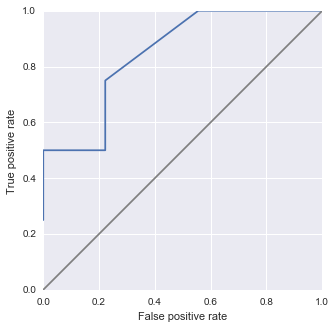

Area under curve: 0.847222222222


In [13]:
clf = gscv_3.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(datanan, targetnan, test_size=0.3, random_state=100)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred0 = clf.predict(X_train)

print 'Confusion matrix on the training set:'
print confusion_matrix(y_train, pred0)
print ''

print 'Confusion matrix on the testing set:'
print confusion_matrix(y_test, pred)
print ''

p, r, f, s = precision_recall_fscore_support(y_test, pred) 
print 'Scores for the two classes (False, True):'
print 'precision:', p[1]
print 'recall:   ', r[1]
print 'f-score:  ', f[1]
print 'suport:   ', s[1]

from sklearn.metrics import roc_curve, auc

y_score = clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, t = roc_curve(y_test, y_score[:, 1])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], color='grey')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

roc_auc = auc(fpr, tpr)
print 'Area under curve:', roc_auc

The previous figures can be explained as follow: the confusion matrix shows how many values in each label class were predicted correctly. The first confusion matrix above shows that the estimator learnt the original set quite good. The second confusion matrix shows that on the testing set the estimator predicted correctly all 9 non-poi values and 2 poi values. It mis-classified two poi values.

The precision and recall follow the definitions given in the class, showing how many selected elements are relevant and respectively how many relevant elements are selected. In our case, the precision shows how many elements classified in as a poi actually belong to the poi class. Zooming in,there were no false positives poi-s and two elements were classified correctly, leading to 2/(2+0) = 1 precision for pois. Recall is being computed in a similar manner: 2 pois elements were correctly classified and we had two false negatives, thus: 2/(2+2) = 0.5.

The f-score is an aggregation of the previous two metrics, offering a harmonic mean of them. The imbalance in the number of pois in the data sets is influencing heavily the recall value across all tried machine learning techniques.

The area-under-curve characterizes the performance of the estimator. Ideally, it would aproach 1 as the blue curve would pass through the top left corner (100% of the values would be classified correctly, hence no false positives). The user can choose the thresholds for the curve such that it achieves a desired ratio between true positives and false positives, function of the application. 

This was an interesting project. The data set is difficult in the sense that it contains little information with respect to the poi. The data set size is very restrictive - splitting the few entries into test/train sets leads to a huge variance in the results. As seen above, if 30% of the data set is used for testing, this will lead to an average of 5 poi-s in the testing set, the imbalance in the data being very large. Even worst results are achieved with the 5 or 10-fold cross validations, as often the test data contains no poi data.

*I hereby confirm that this submission is my work. I have cited above the origins of any parts of the submission that were taken from Websites, books, forums, blog posts, github repositories, etc.*